In [1]:
# http://www.robesafe.uah.es/personal/eduardo.romera/uah-driveset/

# http://www.robesafe.uah.es/personal/eduardo.romera/pdfs/Romera16itsc.pdf
# pdf contains description of data (what each column means)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

import os

import folium
from geopy.distance import distance
# from datetime import datetime
from datetime import datetime, UTC

from ride_parser import UAHRideParser, RealRideParser
from app_data_parser import  generate_acc_from_vel, generate_jerk_from_acc
from PIL import Image

import matplotlib.dates as mdates

In [2]:
def get_df_without_outliers(df_to_describe, display_col_name, physical_qtty_name):
    df_to_describe = df_to_describe.rename(columns={display_col_name : physical_qtty_name})
    series_to_describe = df_to_describe[physical_qtty_name]

    # median_val = series_to_describe.median()
    first_quarter = series_to_describe.quantile(0.25)
    third_quarter = series_to_describe.quantile(0.75)

    quarter_dist = third_quarter - first_quarter

    lower_limit = first_quarter - 1.5 * quarter_dist
    upper_limit = third_quarter + 1.5 * quarter_dist

    filter_for_df = (series_to_describe >= lower_limit) & (series_to_describe <= upper_limit)

    return df_to_describe[filter_for_df]

In [3]:
def base_display_graph(df_to_display, display_col_name, physical_qtty_name, unit):
    fig, axs = plt.subplots(1, 1, figsize=(6.4, 3), layout='constrained')

    df_to_display = df_to_display.rename(columns={display_col_name : physical_qtty_name})

    series_to_display = df_to_display[physical_qtty_name]

    plt.plot("timestamp", physical_qtty_name, data=df_to_display)

    axs.grid(True)
    axs.set_ylabel("%s (%s)" % (physical_qtty_name, unit))
    axs.set_xlabel("Horário UTC")

    first_timestamp = df_to_display.iloc[0]["timestamp"]
    record_day_month_year_string = datetime.fromtimestamp(first_timestamp, UTC).strftime("%d/%m/%Y %H:%M")
    axs.set_title("Captura de %s em " % physical_qtty_name + record_day_month_year_string)

    min_val = series_to_display.min()
    max_val = series_to_display.max()
    median_val = series_to_display.median()

    plt.axhline(y=median_val, color="orange", linestyle="dashed", label="Mediana (%.2f)" % median_val) 
    plt.axhline(y=min_val, color="yellow", linestyle="dashed", label="Valor mínimo (%.2f)" % min_val) 
    plt.axhline(y=max_val, color="red", linestyle="dashed", label="Valor máximo (%.2f)" % max_val) 

    plt.legend(loc='center right', bbox_to_anchor=(1.6, 0.5),
            ncol=1, fancybox=True, shadow=True)

    plt.show()

In [4]:
def display_vel_graph(vel_df):
	base_display_graph(vel_df, "SPEED", "Velocidade", "m/s")

In [5]:
def display_acc_graph(acc_df):
	base_display_graph(acc_df, "acceleration", "Aceleração", "m/s^2")

In [6]:
def display_jerk_graph(jerk_df):
	base_display_graph(jerk_df, "jerk", "Arrancada", "m/s^3")

In [7]:
# ride_root_dir = os.path.join("RealData", "Data_2023-11-03")
ride_root_dir = os.path.join("RealData", "Data_2023-11-20_pt2")
# ride_root_dir = os.path.join("RealData", "FakeTest")
# ride_root_dir = os.path.join("RealData", "Mercedes_25-11-2023")
# ride_root_dir = os.path.join("RealData", "Ix35_Hyundai_25-11-2023")
# ride_root_dir = os.path.join("RealData", "Agressivo_28-11-2023_traj1")
# ride_root_dir = os.path.join("RealData", "Dados_com_millis")


real_ride = RealRideParser(root_dir=ride_root_dir)

latitudes = real_ride.gps_df["lat"]
longitudes = real_ride.gps_df["long"]

qtty_data = len(latitudes)

lat_longs = [(latitudes.iloc[i], longitudes.iloc[i]) for i in range(qtty_data)]

real_ride.accelerometer_df.head(3)

cannot convert 410F3E0:A1008D00000000 to float


/home/arthurpfonseca/Documents/Poli/5oQuadriAula/TCC/data-analysis/dataset_car/ride_parser.py:835: RuntimeWarning: invalid value encountered in divide
  acc_z_car = np.dot(acc_s, gravity_vec) * (gravity_vec / np.linalg.norm(gravity_vec))


,timestamp,acc_x,acc_y,acc_z,filtered_acc_x,filtered_acc_y,filtered_acc_z,grav_x,grav_y,grav_z,acc_z_car_x,acc_z_car_y,acc_z_car_z,remaining_acc_x,remaining_acc_y,remaining_acc_z,acc_resultant,remaining_acc_resultant
0,1.700924e+09,-3.51,6.58,8.34,-3.51,6.58,8.34,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,11.188034,NaN
1,1.700924e+09,0.35,-0.31,0.01,0.35,-0.31,0.01,-1.89,6.36,7.22,0.493605,-1.661020,-1.885623,-0.143605,1.351020,1.895623,0.467654,2.332223
2,1.700924e+09,-1.11,-0.05,-0.54,-1.11,-0.05,-0.54,-1.36,6.17,7.50,0.395093,-1.792445,-2.178823,-1.505093,1.742445,1.638823,1.235395,2.826157


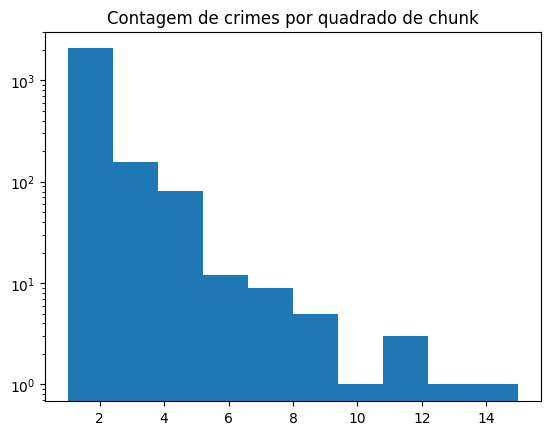

In [8]:
fig1, ax1 = plt.subplots()
ax1.set_title('Contagem de crimes por quadrado de chunk')
counts = real_ride.crime_analyser.car_crimes_df[["chunk_i", "chunk_j"]].groupby(by=["chunk_i", "chunk_j"]).size()
ax1.set_yscale('log')
ax1.hist(list(counts))

# max_count = counts.max()
# ticks = np.array([max_count // i for i in range(1, 10)])
# ax1.set_yticks(counts)

# y_labels = ticks.astype(str)
# ax1.set_yticklabels(y_labels)

plt.show()

In [9]:
real_ride.generate_pdf_metrics()

In [10]:
map = real_ride.create_route_map()
real_ride.calculate_crime_stats(map)[0]

In [11]:
# user_id = "arthurpfonseca@gmail.com"
# date_beg = datetime.strptime("2023-12-01 00:00:00.000", "%Y-%m-%d %H:%M:%S.%f").__str__()
# date_end = datetime.strptime("2023-12-07 23:59:59.999", "%Y-%m-%d %H:%M:%S.%f").__str__()

# real_ride_database = RealRideParser(should_get_data_from_database=True, user_id=user_id, date_beg=date_beg, date_end=date_end)

In [12]:
import requests
import json

# r = requests.post('http://httpbin.org/post', json={"key": "value"})

url = "https://pntdpvkdsc.execute-api.us-east-1.amazonaws.com/default/app_data"
data = {"method": "get_acceleration"}
headers = {'Content-type': 'application/json', 'Accept': 'text/plain'}
r = requests.post(url, data=json.dumps(data), headers=headers)

r.status_code, r.json()

(200,
 {'data': [[1,
    'Sat Dec 02 18:00:49 GMT-03:00 2023',
    None,
    '-0,03',
    '0,09',
    '9,62',
    '1,00',
    '2,00',
    '3,00'],
   [2,
    'Sat Dec 02 17:07:49 GMT-03:00 2023',
    None,
    '-0,03',
    '0,09',
    '9,62',
    '0,00',
    '0,00',
    '0,00'],
   [3,
    'Sat Dec 02 17:07:51 GMT-03:00 2023',
    None,
    '-0,00',
    '-0,01',
    '-0,20',
    '-0,02',
    '0,09',
    '9,81'],
   [4,
    'Sat Dec 02 17:07:53 GMT-03:00 2023',
    None,
    '-0,01',
    '-0,00',
    '-0,17',
    '-0,02',
    '0,09',
    '9,81'],
   [5,
    'Sat Dec 02 17:07:55 GMT-03:00 2023',
    None,
    '-0,00',
    '-0,01',
    '-0,19',
    '-0,02',
    '0,09',
    '9,81'],
   [6,
    'Sat Dec 02 17:07:57 GMT-03:00 2023',
    None,
    '-0,01',
    '-0,01',
    '-0,20',
    '-0,02',
    '0,09',
    '9,81'],
   [7,
    'Sat Dec 02 17:07:59 GMT-03:00 2023',
    None,
    '-0,01',
    '0,01',
    '-0,19',
    '-0,02',
    '0,09',
    '9,81'],
   [8,
    'Sat Dec 02 17:08:01 GMT-03:00

In [13]:
real_ride.obd_data["ENGINE_RPM"]

,timestamp,ENGINE_RPM
0,1.700925e+09,2214.0
1,1.700925e+09,1478.0
2,1.700925e+09,1528.0
3,1.700925e+09,1425.0
4,1.700925e+09,1372.0
...,...,...
518,1.700927e+09,658.0
519,1.700927e+09,662.0
520,1.700927e+09,654.0
521,1.700927e+09,656.0


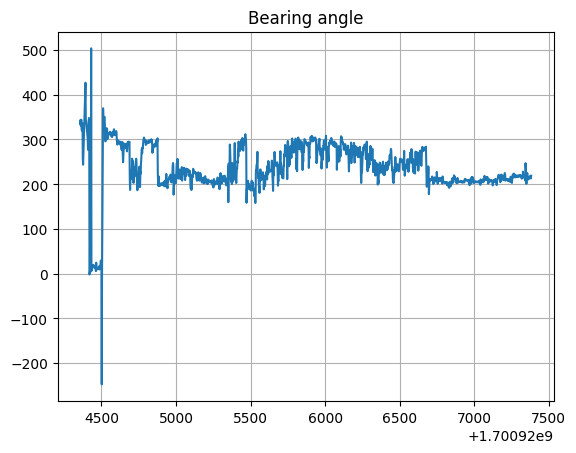

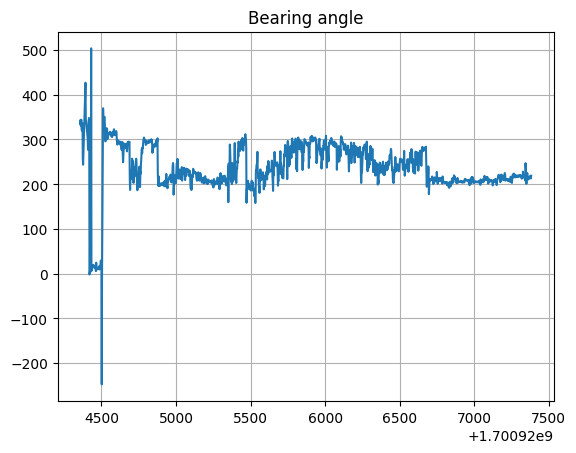

In [14]:
real_ride.generate_graph_for_bearing()

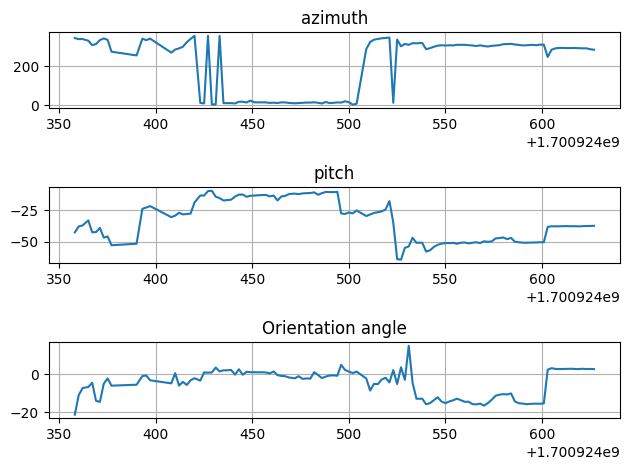

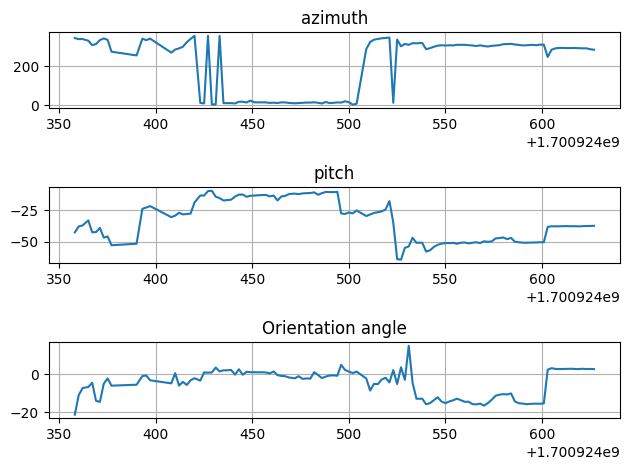

In [15]:
real_ride.generate_graph_for_orientation()

In [16]:
obd_data = real_ride.obd_data

vels_from_obd_df = obd_data["SPEED"]

# display_vel_graph(vels_from_obd_df)

In [17]:
print(real_ride.get_acc_stats())
real_ride.gps_df
vels_from_gps_df = real_ride.create_velocity_from_gps_df()
# display_vel_graph(vels_from_gps_df.iloc[-150:])
# vels_from_gps_df.plot(x="timestamp", y="velocity")

count    1494.000000
mean        0.721600
std         0.830355
min         0.014142
25%         0.255734
50%         0.495729
75%         0.930739
max        11.833330
Name: acc_resultant, dtype: float64


In [18]:
gps_timestamps = vels_from_gps_df["timestamp"]
obd_timestamps = vels_from_obd_df["timestamp"]

min_gps_time = gps_timestamps.min()
max_gps_time = gps_timestamps.max()

min_obd_time = obd_timestamps.min()
max_obd_time = obd_timestamps.max()

min_time_filter = max(min_gps_time, min_obd_time)
max_time_filter = min(max_gps_time, max_obd_time)

min_time_filter, max_time_filter

(1700924544.0, 1700927303.0)

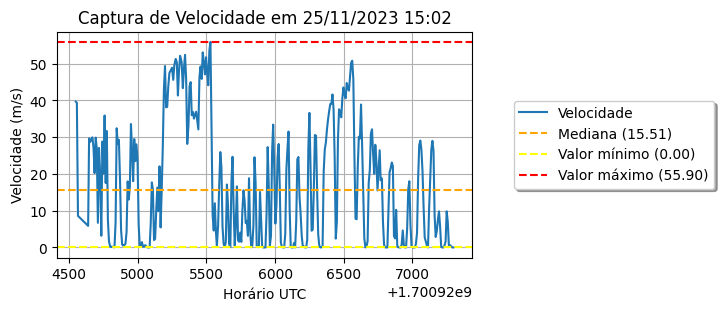

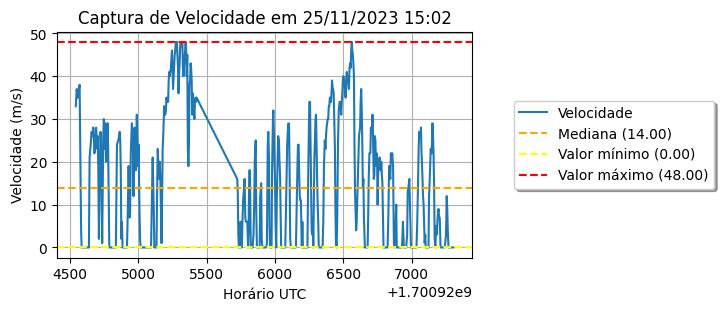

In [19]:
filter_gps = (vels_from_gps_df["timestamp"] >= min_time_filter) & (vels_from_gps_df["timestamp"] <= max_time_filter)
filtered_vels_from_gps_df = vels_from_gps_df[filter_gps]

display_vel_graph(filtered_vels_from_gps_df)

filter_obd = (vels_from_obd_df["timestamp"] >= min_time_filter) & (vels_from_obd_df["timestamp"] <= max_time_filter)
filtered_vels_from_obd_df = vels_from_obd_df[filter_obd]

display_vel_graph(filtered_vels_from_obd_df)

4.6828407166769

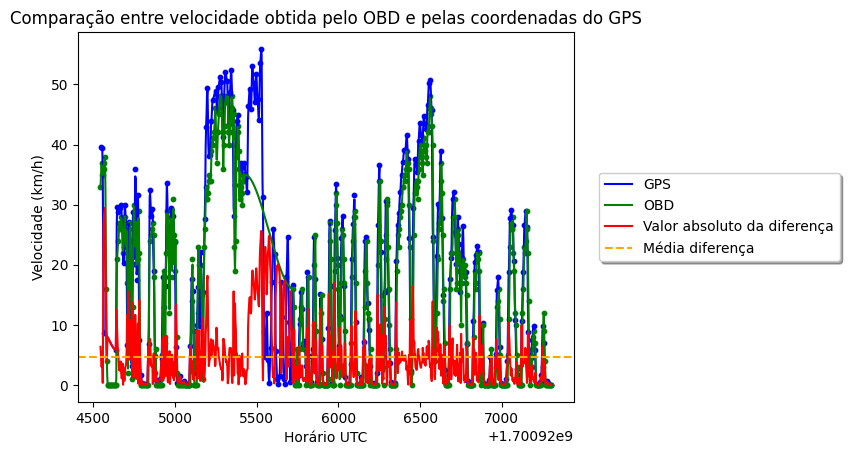

In [20]:
from scipy.interpolate import CubicHermiteSpline

xx = np.linspace(min_time_filter, max_time_filter, 1000)

# GPS
x_gps = filtered_vels_from_gps_df["timestamp"]
y_gps = filtered_vels_from_gps_df["SPEED"]
p_gps = CubicHermiteSpline(x=x_gps, y=y_gps, dydx=np.zeros_like(y_gps))  # interpolator   
plt.scatter(x_gps, y_gps, s=10, c="blue", marker="o", linewidth=1)

# plt.scatter(xx, p(xx), s=[1 for _ in range(len(xx))])
line, = plt.plot(xx, p_gps(xx), label="GPS")
line.set_color("blue")

# OBD
x_obd = filtered_vels_from_obd_df["timestamp"]
y_obd = filtered_vels_from_obd_df["SPEED"]
p_obd = CubicHermiteSpline(x=x_obd, y=y_obd, dydx=np.zeros_like(y_obd))  # interpolator   
plt.scatter(x_obd, y_obd, s=10, c="green", marker="o", linewidth=1)

line, = plt.plot(xx, p_obd(xx), label="OBD")
line.set_color("green")
   
# difference
difference_np_array = abs(p_obd(xx) - p_gps(xx))
mean_diff = difference_np_array.mean()
line, = plt.plot(xx, difference_np_array, label="Valor absoluto da diferença")
line.set_color("red")

plt.axhline(y=mean_diff, color="orange", linestyle="dashed", label="Média diferença") 

plt.legend(loc='center right', bbox_to_anchor=(1.55, 0.5),
          ncol=1, fancybox=True, shadow=True)
plt.ylabel("Velocidade (km/h)")
plt.xlabel("Horário UTC")
plt.title("Comparação entre velocidade obtida pelo OBD e pelas coordenadas do GPS")
mean_diff

In [21]:
# obd_data = get_data_from_app()

# vels_from_obd_df = app_data["SPEED"]
# display_vel_graph(vels_from_obd_df)

# print(app_data["SPEED"])

In [22]:
acc_from_android_df = real_ride.accelerometer_df[["timestamp", "remaining_acc_resultant"]].copy()
acc_from_android_df.rename(columns={"remaining_acc_resultant": "acceleration"}, inplace=True)

acc_from_obd_df = generate_acc_from_vel(vels_from_obd_df)

android_timestamps = acc_from_android_df["timestamp"]
obd_timestamps = acc_from_obd_df["timestamp"]

min_android_time = android_timestamps.min()
max_android_time = android_timestamps.max()

min_obd_time = obd_timestamps.min()
max_obd_time = obd_timestamps.max()

min_time_filter = max(min_android_time, min_obd_time)
max_time_filter = min(max_android_time, max_obd_time)

min_time_filter, max_time_filter

(1700924544.0, 1700927299.0)

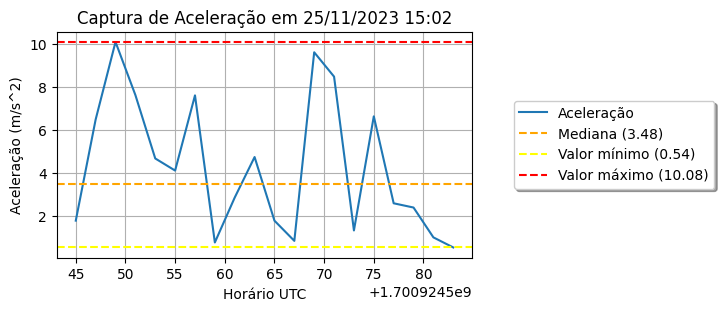

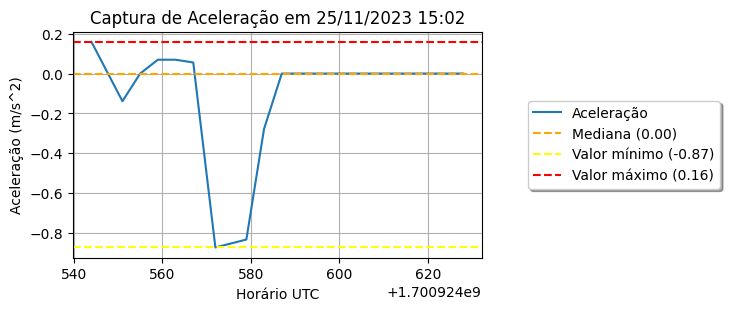

In [23]:
filter_android = (acc_from_android_df["timestamp"] >= min_time_filter) & (acc_from_android_df["timestamp"] <= max_time_filter)
filtered_acc_from_android_df = acc_from_android_df[filter_android].drop_duplicates(subset=["timestamp"])

display_acc_graph(filtered_acc_from_android_df.iloc[0:20])

filter_obd = (acc_from_obd_df["timestamp"] >= min_time_filter) & (acc_from_obd_df["timestamp"] <= max_time_filter)
filtered_acc_from_obd_df = acc_from_obd_df[filter_obd]

display_acc_graph(filtered_acc_from_obd_df.iloc[0:20])

In [24]:
jerk_from_android_df = generate_jerk_from_acc(acc_from_android_df)
jerk_from_obd_df = generate_jerk_from_acc(acc_from_obd_df)

android_timestamps = jerk_from_android_df["timestamp"]
obd_timestamps = jerk_from_obd_df["timestamp"]

min_android_time = android_timestamps.min()
max_android_time = android_timestamps.max()

min_obd_time = obd_timestamps.min()
max_obd_time = obd_timestamps.max()

min_time_filter = max(min_android_time, min_obd_time)
max_time_filter = min(max_android_time, max_obd_time)

min_time_filter, max_time_filter

(1700924544.0, 1700927292.0)

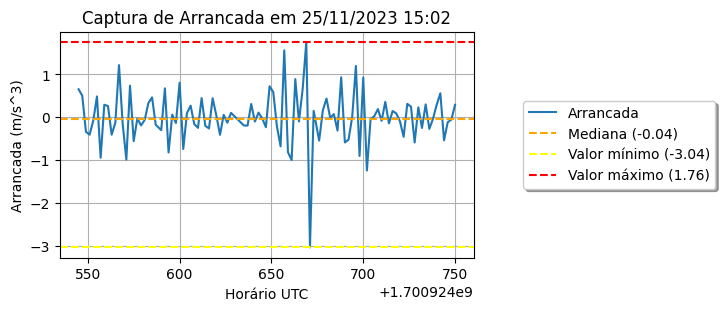

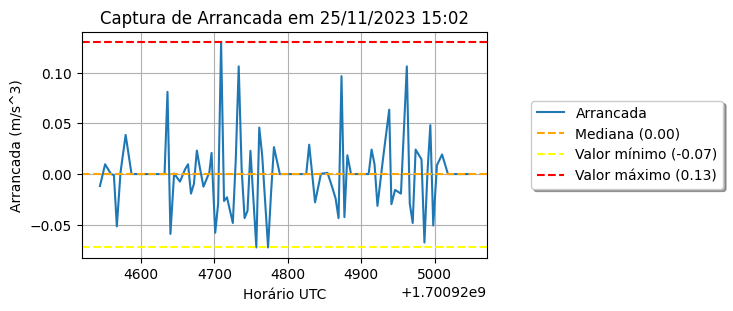

In [25]:
filter_android = (jerk_from_android_df["timestamp"] >= min_time_filter) & (jerk_from_android_df["timestamp"] <= max_time_filter)
filtered_jerk_from_android_df = jerk_from_android_df[filter_android].drop_duplicates(subset=["timestamp"])

display_jerk_graph(filtered_jerk_from_android_df.iloc[0:100])

filter_obd = (jerk_from_obd_df["timestamp"] >= min_time_filter) & (jerk_from_obd_df["timestamp"] <= max_time_filter)
filtered_jerk_from_obd_df = jerk_from_obd_df[filter_obd]

display_jerk_graph(filtered_jerk_from_obd_df.iloc[0:100])

3.268804949807873

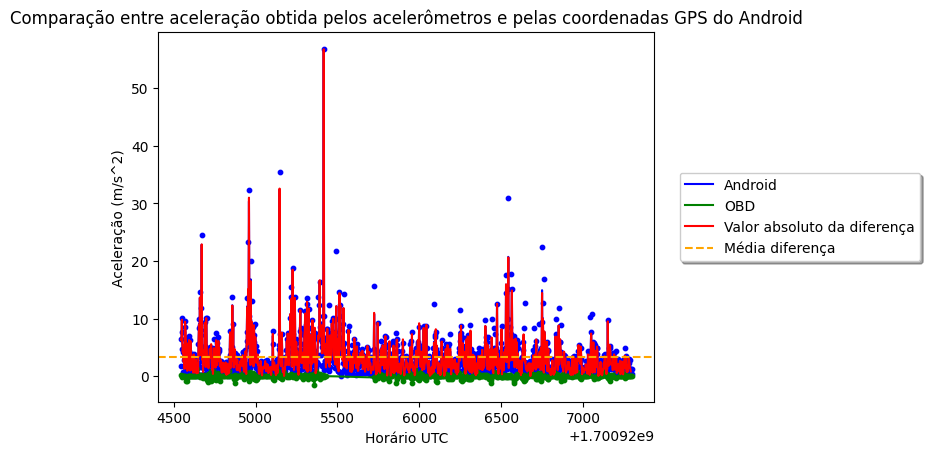

In [26]:
from scipy.interpolate import CubicHermiteSpline

xx = np.linspace(min_time_filter, max_time_filter, 1000)

# Android
x_android = filtered_acc_from_android_df["timestamp"]
y_android = filtered_acc_from_android_df["acceleration"]
p_android = CubicHermiteSpline(x=x_android, y=y_android, dydx=np.zeros_like(y_android))  # interpolator   
plt.scatter(x_android, y_android, s=10, c="blue", marker="o", linewidth=1)

# plt.scatter(xx, p(xx), s=[1 for _ in range(len(xx))])
line, = plt.plot(xx, p_android(xx), label="Android")
line.set_color("blue")

# OBD
x_obd = filtered_acc_from_obd_df["timestamp"]
y_obd = filtered_acc_from_obd_df["acceleration"]
p_obd = CubicHermiteSpline(x=x_obd, y=y_obd, dydx=np.zeros_like(y_obd))  # interpolator   
plt.scatter(x_obd, y_obd, s=10, c="green", marker="o", linewidth=1)

line, = plt.plot(xx, p_obd(xx), label="OBD")
line.set_color("green")
   
# difference
difference_np_array = abs(p_obd(xx) - p_android(xx))
mean_diff = difference_np_array.mean()
line, = plt.plot(xx, difference_np_array, label="Valor absoluto da diferença")
line.set_color("red")

plt.axhline(y=mean_diff, color="orange", linestyle="dashed", label="Média diferença") 

plt.legend(loc='center right', bbox_to_anchor=(1.55, 0.5),
          ncol=1, fancybox=True, shadow=True)
plt.ylabel("Aceleração (m/s^2)")
plt.xlabel("Horário UTC")
plt.title("Comparação entre aceleração obtida pelos acelerômetros e pelas coordenadas GPS do Android")
mean_diff

4.7074282845748066

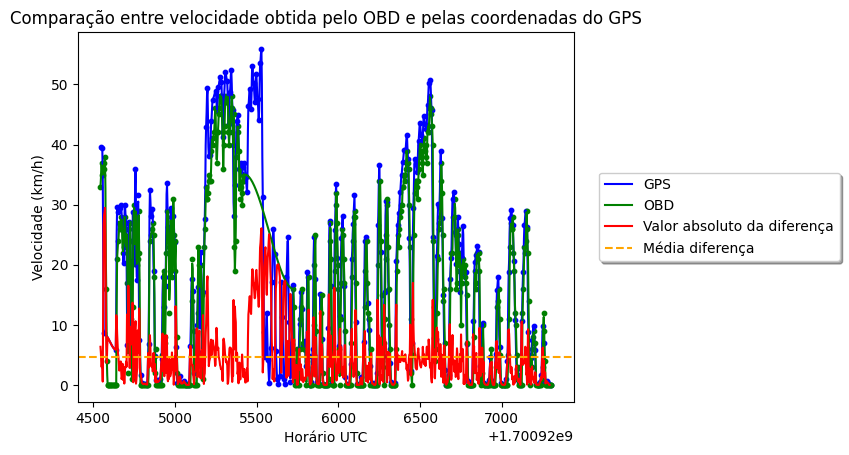

In [27]:
from scipy.interpolate import CubicHermiteSpline

xx = np.linspace(min_time_filter, max_time_filter, 1000)

# GPS
x_gps = filtered_vels_from_gps_df["timestamp"]
y_gps = filtered_vels_from_gps_df["SPEED"]
p_gps = CubicHermiteSpline(x=x_gps, y=y_gps, dydx=np.zeros_like(y_gps))  # interpolator   
plt.scatter(x_gps, y_gps, s=10, c="blue", marker="o", linewidth=1)

# plt.scatter(xx, p(xx), s=[1 for _ in range(len(xx))])
line, = plt.plot(xx, p_gps(xx), label="GPS")
line.set_color("blue")

# OBD
x_obd = filtered_vels_from_obd_df["timestamp"]
y_obd = filtered_vels_from_obd_df["SPEED"]
p_obd = CubicHermiteSpline(x=x_obd, y=y_obd, dydx=np.zeros_like(y_obd))  # interpolator   
plt.scatter(x_obd, y_obd, s=10, c="green", marker="o", linewidth=1)

line, = plt.plot(xx, p_obd(xx), label="OBD")
line.set_color("green")
   
# difference
difference_np_array = abs(p_obd(xx) - p_gps(xx))
mean_diff = difference_np_array.mean()
line, = plt.plot(xx, difference_np_array, label="Valor absoluto da diferença")
line.set_color("red")

plt.axhline(y=mean_diff, color="orange", linestyle="dashed", label="Média diferença") 

plt.legend(loc='center right', bbox_to_anchor=(1.55, 0.5),
          ncol=1, fancybox=True, shadow=True)
plt.ylabel("Velocidade (km/h)")
plt.xlabel("Horário UTC")
plt.title("Comparação entre velocidade obtida pelo OBD e pelas coordenadas do GPS")
mean_diff

In [28]:
start_lat_long = lat_longs[0]
end_lat_long = lat_longs[-1]

mean_lat = latitudes.mean()
mean_long = longitudes.mean()

start_lat_long, end_lat_long, qtty_data

((-23.5503837, -46.6640524), (-23.554333, -46.5665698), 362)

In [29]:
map = folium.Map(location=[mean_lat, mean_long], zoom_start=14, control_scale=True)

folium.Marker(start_lat_long, popup="start").add_to(map)
folium.Marker(end_lat_long, popup="end").add_to(map)

In [30]:
for i in range(qtty_data - 1):
	location_1 = lat_longs[i]
	location_2 = lat_longs[i + 1]

	folium.PolyLine([location_1, location_2],
					color='red',
					weight=5,
					opacity=0.4).add_to(map)

real_ride.create_route_map()

In [31]:
accelerometer_df = real_ride.accelerometer_df
last_timestamp = accelerometer_df.timestamp.iloc[-1] # .timestamp()
delta_time_size = 100 	# 100 s
frame_granularity = 10 	# 50 s
qtty_frames = (last_timestamp - delta_time_size) // frame_granularity

filtered_accelerations_df = accelerometer_df

print("last_timestamp", last_timestamp)
print("qtty_frames", qtty_frames)
print("last_timestamp", last_timestamp)

qtty_frames = min(qtty_frames, 100)

# generate_3_axis_acc_graph(accelerometer_df, frame_granularity, delta_time_size, 0)

for i in range(10): #qtty_frames):
    real_ride.generate_3_axis_acc_graph(frame_granularity, delta_time_size, i)


last_timestamp 1700927383.0
qtty_frames 170092728.0
last_timestamp 1700927383.0


In [32]:
# vels_from_gps_no_outliers_df = get_df_without_outliers(filtered_vels_from_gps_df, "SPEED", "Velocidade")
# vels_from_obd_no_outliersdf = get_df_without_outliers(filtered_vels_from_obd_df, "SPEED", "Velocidade")

acc_from_android_no_outliers_df = get_df_without_outliers(filtered_acc_from_android_df, "acceleration", "Aceleração")
acc_from_obd_no_outliers_df = get_df_without_outliers(filtered_acc_from_obd_df, "acceleration", "Aceleração")

jerk_from_android_no_outliers_df = get_df_without_outliers(filtered_jerk_from_android_df, "jerk", "Arrancada")
jerk_from_obd_no_outliers_df = get_df_without_outliers(filtered_jerk_from_obd_df, "jerk", "Arrancada")

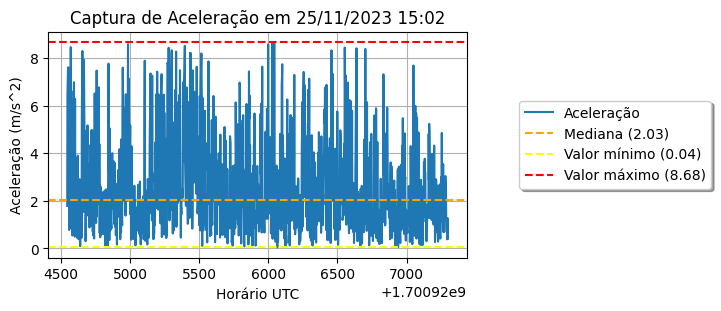

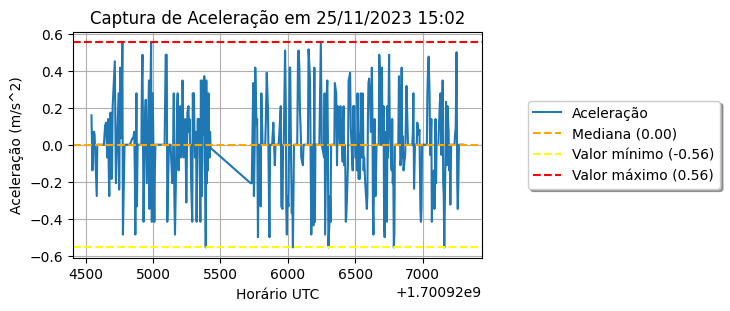

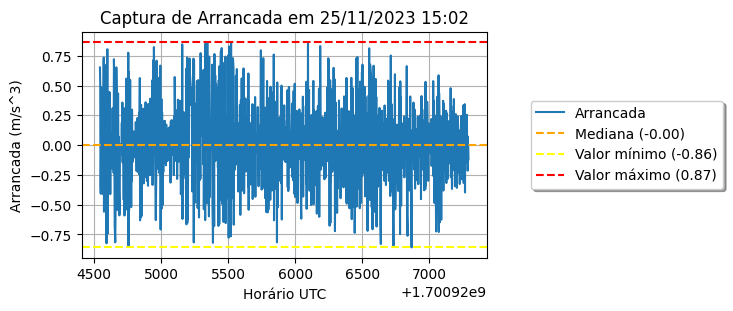

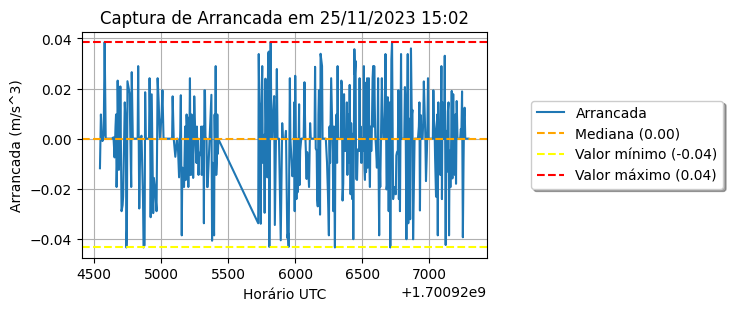

In [33]:
# display_vel_graph(vels_from_gps_no_outliers_df)
# display_vel_graph(vels_from_obd_no_outliers_df)

display_acc_graph(acc_from_android_no_outliers_df)
display_acc_graph(acc_from_obd_no_outliers_df)

display_jerk_graph(jerk_from_android_no_outliers_df)
display_jerk_graph(jerk_from_obd_no_outliers_df)

In [34]:
# real_ride.calculate_acc_stats_near_stop()

Objetivos:
- [x] Gerar mapa com a rota feita por cada um dos motoristas
- [] Sincronizar vídeo com eventos de aceleração

In [35]:
# ride_root_dir = os.path.join("UAH-DRIVESET-v1", "D1", "20151110175712-16km-D1-NORMAL1-SECONDARY")
ride_root_dir = os.path.join("UAH-DRIVESET-v1", "D1", "20151111125233-24km-D1-AGGRESSIVE-MOTORWAY")

ride = UAHRideParser(ride_root_dir)

# col_names = [str(i) for i in range(13)]
# col_names = ["timestamp", "speed", "lat", "long", "altitude", "vert accuracy", "horiz accuracy", "course", "difcourse", "?1", "?2", "?3", "?4"]
# pd.read_csv(gps_file_path, sep=" ", names=col_names)

ride.gps_df
ride.accelerometer_df

,timestamp,is speed gt 50 kmh,acc_x,acc_y,acc_z,filtered_acc_x,filtered_acc_y,filtered_acc_z,roll_degrees,pitch_degrees,yaw_degrees,?1,?2,?3,?4,acc_resultant
0,8.02,1,-0.013,-0.021,0.011,-0.031,-0.009,0.013,-1.627,-0.011,0.294,NaN,NaN,NaN,NaN,0.027037
1,8.12,1,-0.008,-0.005,-0.017,-0.018,-0.011,0.002,-1.626,-0.007,0.297,NaN,NaN,NaN,NaN,0.019442
2,8.22,1,-0.013,-0.026,-0.012,-0.005,-0.011,-0.008,-1.625,-0.003,0.299,NaN,NaN,NaN,NaN,0.031448
3,8.32,1,-0.049,-0.018,0.033,-0.029,-0.018,0.002,-1.626,0.001,0.302,NaN,NaN,NaN,NaN,0.061758
4,8.43,1,0.016,0.009,0.014,-0.021,-0.008,0.021,-1.627,0.004,0.304,NaN,NaN,NaN,NaN,0.023087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7282,745.45,1,0.004,-0.009,0.019,-0.003,-0.017,0.009,-1.527,0.010,-2.639,NaN,NaN,NaN,NaN,0.021401
7283,745.55,1,-0.013,-0.019,-0.049,0.004,-0.033,-0.005,-1.525,0.015,-2.636,NaN,NaN,NaN,NaN,0.054139
7284,745.65,1,-0.082,-0.012,0.001,-0.043,-0.007,-0.024,-1.526,0.014,-2.637,NaN,NaN,NaN,NaN,0.082879
7285,745.75,1,-0.041,-0.037,0.025,-0.052,-0.021,0.010,-1.528,0.014,-2.632,NaN,NaN,NaN,NaN,0.060622


In [36]:
accelerometer_df = ride.accelerometer_df
oldest_timestamp = int(accelerometer_df.timestamp.iloc[-1])
delta_time_size = 20
frame_granularity = 1
qtty_frames = (oldest_timestamp - delta_time_size) // frame_granularity

print("qtty_frames", qtty_frames)
print("oldest_timestamp", oldest_timestamp)

for i in range(10): #qtty_frames):
    with ProcessPoolExecutor(max_workers=10) as executor:
        future = executor.submit(ride.foo, accelerometer_df, frame_granularity, delta_time_size, i)

    # print(future.result())

# plt.show()
# RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.

qtty_frames 725
oldest_timestamp 745


In [37]:
# fig, axs = plt.subplots(ncols=1, nrows=4)

# accelerometer_df = ride.accelerometer_df
# accelerometer_df = accelerometer_df[accelerometer_df.timestamp < 20]
# filtered_acc_x = accelerometer_df["filtered_acc_x"]
# filtered_acc_y = accelerometer_df["filtered_acc_y"]
# filtered_acc_z = accelerometer_df["filtered_acc_z"]
# acc_resultant = accelerometer_df["acc_resultant"]
# timestamp = accelerometer_df["timestamp"]

# # axs[0].scatter(timestamp, filtered_acc_x, s=0.1)
# axs[0].plot(timestamp, filtered_acc_x) #, "-o")
# axs[0].set_title("filtered_acc_x")

# axs[1].plot(timestamp, filtered_acc_y)
# axs[1].set_title("filtered_acc_y")

# axs[2].plot(timestamp, filtered_acc_z)
# axs[2].set_title("filtered_acc_z")

# axs[3].plot(timestamp, acc_resultant)
# axs[3].set_title("acc_resultant")

# fig.tight_layout()

# plt.show()

In [38]:
# import numpy as np
# from scipy.spatial.distance import euclidean

# from fastdtw import fastdtw

# # x = np.array([[1,1], [2,2], [3,3], [4,4], [5,5]])
# # y = np.array([[2,2], [3,3], [4,4]])

# x = [tuple(el) for _, el in vels_from_obd_df.iterrows()][-107:]
# y = [tuple(el) for _, el in vels_from_gps_df.iterrows()][-107:]

# distance, path = fastdtw(x, y, dist=euclidean)
# print(distance, path)

In [39]:
# def display_vel_graph(vel_df):
#     #  https://stackoverflow.com/questions/75566545/problem-with-matplotlib-date-formatting-and-conversion-from-epoch-time-overlowe
# 	plt.rcParams['date.converter'] = 'concise'

# 	fig, axs = plt.subplots(1, 1, figsize=(6.4, 3), layout='constrained')
#     # common to all three:
#     # for ax in axs:
# 	# ax[1].plot(time.astype('datetime64[s]'), y)

# 	# ax.plot('date', 'adj_close', data=data)
# 	plt.plot("timestamp", "SPEED", data=vel_df)
# 	# Major ticks every half year, minor ticks every second,
# 	# axs.xaxis.set_major_locator(mdates.MinuteLocator(byminute=range(60)))
# 	# axs.xaxis.set_minor_locator(mdates.MinuteLocator())
# 	axs.grid(True)
# 	axs.set_ylabel("Velocidade (km/h)")
# 	axs.set_xlabel("Horário UTC")

# 	# ax = axs[0]
# 	first_timestamp = vel_df.iloc[0]["timestamp"]
# 	record_day_month_year_string = datetime.utcfromtimestamp(first_timestamp).strftime("%d/%m/%Y")
# 	axs.set_title("Captura " + record_day_month_year_string)

# 	# axs.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# 	# # Rotates and right-aligns the x labels so they don't crowd each other.
# 	# for label in axs.get_xticklabels(which='major'):
# 	# 	label.set(rotation=30, horizontalalignment='right')

# 	plt.show()

In [40]:
imgs = ride.generate_acc_sub_graph()

# im = Image.open(next(imgs))
# im.show(title="My Image")

In [41]:
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# import matplotlib.animation as animation

# import numpy
# from PIL import Image

# n = 20

# img = [] # some array of images
# for i in range(n):
# 	imarray = numpy.random.rand(100,100,3) * 255
# 	im = Image.fromarray(imarray.astype('uint8')).convert('RGBA')
# 	img.append(im)

# frames = [] # for storing the generated images
# fig = plt.figure()
# for i in range(n):
# 	frames.append([plt.imshow(img[i], cmap=cm.Greys_r,animated=True)])

# ani = animation.ArtistAnimation(fig, frames, blit=True)

# writergif = animation.PillowWriter(fps=1)
# ani.save('movie.gif', writer=writergif)
# plt.show()

In [42]:
# import io
# from PIL import Image
# import matplotlib.pyplot as plt

# plt.rcParams["figure.figsize"] = [7.50, 3.50]
# plt.rcParams["figure.autolayout"] = True

# plt.figure()
# plt.plot([1, 2])

# img_buf = io.BytesIO()
# plt.savefig(img_buf, format='png')

# im = Image.open(img_buf)
# im.show(title="My Image")

# img_buf.close()